In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [18]:
df = pd.read_csv('data_for_model.csv')

In [19]:
df['date'] = pd.to_datetime(df['date'])
df['annee'] = df['date'].dt.year
df['mois'] = df['date'].dt.month
df['jour_semaine'] = df['date'].dt.dayofweek
df.drop(columns=['date'], inplace=True)

In [20]:
X = df.drop(columns=['catastrophe'])
y = df['catastrophe']

In [21]:
cat_cols = ['quartier']
num_cols = [col for col in X.columns if col not in cat_cols]

In [22]:
preprocessor = ColumnTransformer([
    ('quartier_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
], remainder='passthrough')


In [23]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

In [24]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
param_grid = {
    'classifier__max_iter': [100, 200, 300],
    'classifier__max_depth': [3, 5, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__min_samples_leaf': [20, 50, 100]
}

grid = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=3)
grid.fit(X_train, y_train)

/Users/corentinsanjuan/Developer/YNOV/challenge/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('quartier_enc',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['quartier'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 10],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__min_samples_leaf': [20, 50, 100]},
             scoring='f1_macro')

In [27]:
y_pred = grid.predict(X_test)
print("Best params:", grid.best_params_)
print(classification_report(y_test, y_pred))

Best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__max_iter': 200, 'classifier__min_samples_leaf': 50}
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       256
           1       0.58      1.00      0.74        43
           2       0.71      0.91      0.80       107
           3       1.00      0.51      0.67       273

    accuracy                           0.78       679
   macro avg       0.76      0.85      0.77       679
weighted avg       0.84      0.78      0.77       679



## Évaluation du modèle

Après avoir entraîné notre modèle HistGradientBoostingClassifier avec les meilleurs paramètres trouvés par GridSearchCV, nous allons analyser ses performances à l'aide du rapport de classification et d'une matrice de confusion.

La matrice de confusion nous donne une vision plus détaillée des performances de notre modèle pour chaque classe de catastrophe:

- Les valeurs sur la **diagonale** représentent les **prédictions correctes** (vrais positifs pour chaque classe)
- Les valeurs hors diagonale représentent les **erreurs de classification**
- Les valeurs dans une même colonne (hors diagonale) sont des **faux positifs** pour cette classe
- Les valeurs dans une même ligne (hors diagonale) sont des **faux négatifs** pour cette classe

Cette visualisation nous permet d'identifier:
1. Les classes que le modèle a du mal à différencier
2. Les déséquilibres dans la précision entre les différentes classes
3. Les types de catastrophes qui pourraient nécessiter plus de données ou des caractéristiques supplémentaires pour être correctement prédits

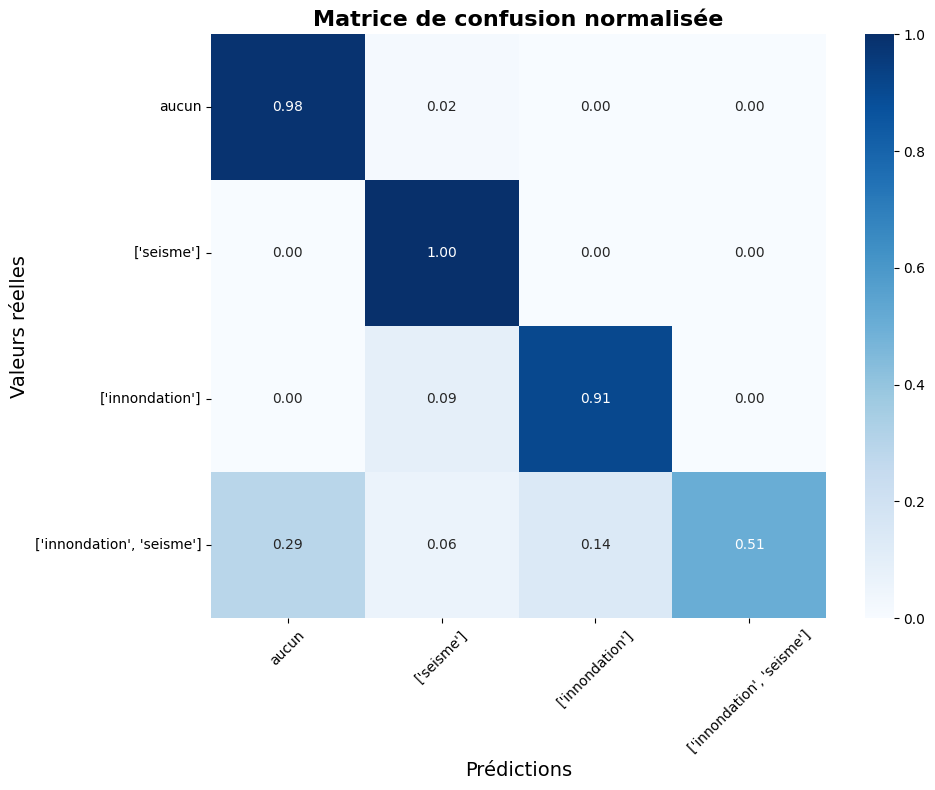

In [ ]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
cm_norm_df = pd.DataFrame(cm_norm, index=range(len(catastrophe_types)), columns=range(len(catastrophe_types)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm_df, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1, cbar=True)

plt.xlabel('Prédictions', fontsize=14)
plt.ylabel('Valeurs réelles', fontsize=14)
plt.title('Matrice de confusion normalisée', fontsize=16, fontweight='bold')

if len(catastrophe_types) < 10:
    try:
        plt.xticks(np.arange(len(catastrophe_types)) + 0.5, catastrophe_types, rotation=45)
        plt.yticks(np.arange(len(catastrophe_types)) + 0.5, catastrophe_types, rotation=0)
    except:
        pass

plt.tight_layout()
plt.show()